### 統計學習與深度學習
### Homework 3


請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料。

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving namesex_data_v2.csv to namesex_data_v2.csv
User uploaded file "namesex_data_v2.csv" with length 127854 bytes


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

OrderedDict([('gname', '承憲'), ('sex', '1'), ('fold', '9')])
OrderedDict([('gname', '均平'), ('sex', '1'), ('fold', '7')])
OrderedDict([('gname', '思安'), ('sex', '0'), ('fold', '6')])
OrderedDict([('gname', '佑誠'), ('sex', '1'), ('fold', '3')])
OrderedDict([('gname', '乃馨'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '婕'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '冠瑜'), ('sex', '0'), ('fold', '1')])
OrderedDict([('gname', '冠學'), ('sex', '1'), ('fold', '0')])
OrderedDict([('gname', '立翰'), ('sex', '1'), ('fold', '2')])
OrderedDict([('gname', '以柔'), ('sex', '0'), ('fold', '6')])


接下來看一些統計數字:

In [ ]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [ ]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


這個資料集的男女比率還算是平均，男性佔了47.94%。

我們用了比較迂迴的方式讀檔案，Pandas其實可以直接讀csv檔。接下來做一些基本的資料分析。我們關心幾件事:
* 最常見的名子
* 共有多少個不重複的名子
* 有多少難判斷男女的名子

要回答這些問題，首先對名子加總，計算數量與男性比率，排序之後列出前20個名子:

In [ ]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

最常見的20個名子:


,name-,sex-mean,sex-count
3738,承恩,1.000000,20
918,冠廷,1.000000,20
2506,宜蓁,0.000000,18
545,佳穎,0.000000,16
3196,彥廷,0.923077,13
913,冠宇,1.000000,13
3390,思妤,0.000000,13
1019,凱翔,1.000000,13
3769,承翰,1.000000,13
3477,怡萱,0.000000,13


由上面的列表看來，最常見的男性名子是承恩與冠廷，最常見的女性名子是宜蓁與佳穎。而這些常見的名子男性比率都非常接近0或1，表示這些名子沒有性別混淆的問題。

另外一個問題是有多少名子只出現一次:

In [ ]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


由結果看來，名子在資料集中只出現一次的比率很高，有65%。也就是說，如果單純的使用訓練資料中出現的名子做為特徵，模型應該會有很差的預測能力。

#### <font color=#800000>為了處理這個問題，我們在接下來的任務中，會使用"Unigram + Full Name"的特徵表示，比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。</font>

最後我們來看看性別混淆的名子:

In [ ]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


難以區分性別的名子總數並不高，所占總體資料的比率也很低，只有1.26%，因此不用擔心這個因素會影響預測準確率。

下面來看看幾個容易混淆性別的名子:

In [ ]:
sex_amb.head()

,name-,sex-mean,sex-count
6777,育瑋,0.5,4
338,以恩,0.5,4
7783,郁軒,0.5,4
2513,宜謙,0.5,4
5920,祐嘉,0.5,4


In [ ]:
sex_amb.iloc[1, 0][0]

'以'

#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

In [47]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

# 先將各名字（未切割）當作category
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(name_df)

enc.categories_

[array([0, 1]),
 array(['一安', '一宸', '一帆', ..., '齡捷', '龍昀', '龍昇'], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [48]:
# 切割各category中的單個字成為新的category
for i in range(len(enc.categories_[1])):
    if len(enc.categories_[1][i]) == 1: # 如果名字只有單個字就跳過
        continue
    else:
        for j in range(len(enc.categories_[1][i])):
            if enc.categories_[1][i][j] in enc.categories_[1]: # 如果已經有了就跳過
                continue
            else:
                enc.categories_[1] = np.append(enc.categories_[1], enc.categories_[1][i][j]) # add a new element to category

In [49]:
enc.categories_

[array([0, 1]),
 array(['一安', '一宸', '一帆', ..., '高', '鯉', '麓'], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [50]:
category = enc.categories_[1] # 取出我們要的元素
category.shape

(9572,)

In [ ]:
x = name_df.iloc[:, 1] # 單單取出name

In [ ]:
x = np.c_[x, np.zeros(x.shape[0])] # the new column (2nd column) is for _other_feather_

In [ ]:
x.shape

(10730, 2)

In [ ]:
x

array([['承憲', 0.0],
       ['均平', 0.0],
       ['思安', 0.0],
       ...,
       ['又華', 0.0],
       ['子晉', 0.0],
       ['芸靜', 0.0]], dtype=object)

In [ ]:
ind_del_cate = np.array([]) # the index of column that need to be deleted 

In [ ]:
for i in range(len(category)):
    x = np.c_[x, np.zeros(x.shape[0])]
    for j in range(x.shape[0]):
        if category[i] in x[j][0]:
            x[j][-1] = 1
    
    if x[:, -1].sum(axis=0) < 2:
        ind_del_cate = np.append(ind_del_cate, i)
        index = np.where(x[:, -1] == 1)
        for k in index:
            x[k, 1] = 1
        x = np.delete(x, -1, 1)
    

In [58]:
x.shape

(10730, 2233)

In [69]:
ind_del_cate = ind_del_cate[::-1] #反轉

In [70]:
ind_del_cate

array([9.571e+03, 9.570e+03, 9.568e+03, ..., 2.000e+00, 1.000e+00,
       0.000e+00])

In [71]:
for i in ind_del_cate: # 將要被捨棄的category刪掉
  category = np.delete(category, int(i))

In [72]:
category.shape

(2231,)

In [60]:
# 將sex與fold加回x，在第2233與2234column
x = np.c_[x, name_df.iloc[:, 0]]
x = np.c_[x, name_df.iloc[:, 2]]

In [61]:
# 先篩選fold，再依x, y分別指示column

x_train = x[x[:, -1] <= 6][:, 1:2233]
y_train = x[x[:, -1] <= 6][:, -2]
x_valid = x[x[:, -1] == 7][:, 1:2233]
y_valid = x[x[:, -1] == 7][:, -2]
x_stack = x[x[:, -1] == 8][:, 1:2233]
y_stack = x[x[:, -1] == 8][:, -2]
x_test = x[x[:, -1] == 9][:, 1:2233]
y_test = x[x[:, -1] == 9][:, -2]

y_train=y_train.astype('int')
y_valid=y_valid.astype('int')
y_stack=y_stack.astype('int')
y_test=y_test.astype('int')

In [62]:
print(x_train.shape) # 2232代表第一個column是_Other_Feature_其他的再category
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_stack.shape)
print(y_stack.shape)
print(x_test.shape)
print(y_test.shape)

(7483, 2232)
(7483,)
(1110, 2232)
(1110,)
(1073, 2232)
(1073,)
(1064, 2232)
(1064,)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。


In [73]:
from sklearn import linear_model
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [74]:
r = 10000000**(1/19)

grid = np.array([])

for i in range(20):
  grid = np.append(grid, (10**(-4))*(r**(i)))

In [75]:
grid

array([1.00000000e-04, 2.33572147e-04, 5.45559478e-04, 1.27427499e-03,
       2.97635144e-03, 6.95192796e-03, 1.62377674e-02, 3.79269019e-02,
       8.85866790e-02, 2.06913808e-01, 4.83293024e-01, 1.12883789e+00,
       2.63665090e+00, 6.15848211e+00, 1.43844989e+01, 3.35981829e+01,
       7.84759970e+01, 1.83298071e+02, 4.28133240e+02, 1.00000000e+03])

In [76]:
biggest_score = 0
bestc = 0

for i in grid:
  clf = LogisticRegression(random_state=0, C=i, max_iter=1000)
  clf.fit(x_valid, y_valid)
  score = clf.score(x_valid, y_valid)
  if score > biggest_score:
    biggest_score = score
    bestc = i

In [77]:
x_train_valid = np.r_[x_train, x_valid]
y_train_valid = np.r_[y_train, y_valid]

clf = LogisticRegression(random_state=0, C=bestc, max_iter=1000)

# use x_train and x_valid to train the model
clf.fit(x_train_valid, y_train_valid)

# predict y from x_test
predict_y_test = clf.predict(x_test)

In [78]:
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
  # Accuracy = (TP+TN)/(P+N)
  # Precision = TP/(TP+FP)
  # Recall (TP rate) = TP/P=TP/(TP+FN)
  
  if y_test[i] == 1:
    P += 1
    if predict_y_test[i] == 1:
      TP += 1
    else:
      FN += 1
  else:
    N += 1
    if predict_y_test[i] == 0:
      TN += 1
    else:
      FP += 1

Accuracy = (TP+TN)/(P+N)
Precision = TP/(TP+FP)
Recall = TP/P
Score = clf.score(x_test, y_test)

print("Accuracy of test data is ", Accuracy)
print("Precision of test data is ", Precision)
print("Recall of test data is ", Recall)
print("Recall of test data is ", Recall)
print("Score of test data is ", Score)
  

Accuracy of test data is  0.8843984962406015
Precision of test data is  0.8596837944664032
Recall of test data is  0.893223819301848
Recall of test data is  0.893223819301848
Score of test data is  0.8843984962406015


In [79]:
abs_coef = abs(clf.coef_[0])

In [80]:
ind = np.argpartition(abs_coef, -20)[-20:]
clf.coef_[0][ind]

array([-10.39034711, -10.41928437,  10.4643527 , -10.6064291 ,
       -11.06817911, -11.2496625 ,  10.69624969, -11.61391376,
       -11.50518635, -11.28135072, -11.67316676, -12.26246064,
        13.20719451, -11.95554131,  12.61680451,  12.26398946,
       -11.89890363, -11.84696768, -11.95401642, -12.03742553])

In [81]:
# 若ind為0，則代表_Other_Feature_很有用；為1，則代表category[0]很有用
ind

array([1763, 1724, 2056, 1524, 2146, 1503, 1443, 1270, 1550, 1644,  348,
       1940, 1472,  359, 1460, 1469, 1643, 1660, 1650, 1278])

In [82]:
for i, coef in zip(ind, clf.coef_[0][ind]):
  print(category[i - 1], "為前20大影響的名字元素，係數為", coef)

嬅 為前20大影響的名字元素，係數為 -10.390347108463384
螢 為前20大影響的名字元素，係數為 -10.419284368978426
松 為前20大影響的名字元素，係數為 10.464352704674242
絜 為前20大影響的名字元素，係數為 -10.606429099434735
絃 為前20大影響的名字元素，係數為 -11.068179113997788
卉 為前20大影響的名字元素，係數為 -11.24966250221123
顥 為前20大影響的名字元素，係數為 10.696249688350276
萱 為前20大影響的名字元素，係數為 -11.61391376331962
凌 為前20大影響的名字元素，係數為 -11.505186352496255
美 為前20大影響的名字元素，係數為 -11.281350724266902
婕 為前20大影響的名字元素，係數為 -11.67316676277233
嵐 為前20大影響的名字元素，係數為 -12.262460637259034
傑 為前20大影響的名字元素，係數為 13.207194505763152
婷 為前20大影響的名字元素，係數為 -11.955541308969297
森 為前20大影響的名字元素，係數為 12.616804510946423
鋒 為前20大影響的名字元素，係數為 12.26398946442726
綾 為前20大影響的名字元素，係數為 -11.898903633684654
玲 為前20大影響的名字元素，係數為 -11.846967683922726
雯 為前20大影響的名字元素，係數為 -11.954016415836133
薇 為前20大影響的名字元素，係數為 -12.037425527812102


Precision與Score都滿大的，而前20大的名字元素也都滿符合直觀男女分別會被取的名稱，像是嬅、萱、美、傑、婷、鋒、雯以及薇。

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [83]:
from sklearn.ensemble import RandomForestClassifier

r = 200**(1/9)
grid = np.array([])
for i in range(10):
  grid = np.append(grid, round((5)*(r**(i))))
"""
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.predict([[0, 0, 0, 0]]))


"""
biggest_score = 0
best_nest = 0

for i in grid:
  clf = RandomForestClassifier(random_state=0, n_estimators=int(i))
  clf.fit(x_valid, y_valid)
  score = clf.score(x_valid, y_valid)
  if score > biggest_score:
    biggest_score = score
    best_nest = i

In [84]:
clf = RandomForestClassifier(random_state=0, n_estimators=int(best_nest))

# use x_train and x_valid to train the model
clf.fit(x_train_valid, y_train_valid)

# predict y from x_test
predict_y_test = clf.predict(x_test)

In [85]:
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
  # Accuracy = (TP+TN)/(P+N)
  # Precision = TP/(TP+FP)
  # Recall (TP rate) = TP/P=TP/(TP+FN)
  
  if y_test[i] == 1:
    P += 1
    if predict_y_test[i] == 1:
      TP += 1
    else:
      FN += 1
  else:
    N += 1
    if predict_y_test[i] == 0:
      TN += 1
    else:
      FP += 1

Accuracy = (TP+TN)/(P+N)
Precision = TP/(TP+FP)
Recall = TP/P
Score = clf.score(x_test, y_test)

print("Accuracy of test data is ", Accuracy)
print("Precision of test data is ", Precision)
print("Recall of test data is ", Recall)
print("Recall of test data is ", Recall)
print("Score of test data is ", Score)

Accuracy of test data is  0.8421052631578947
Precision of test data is  0.8109161793372319
Recall of test data is  0.8542094455852156
Recall of test data is  0.8542094455852156
Score of test data is  0.8421052631578947


In [118]:
ind = np.argpartition(clf.feature_importances_, -20)[-20:]
ind

array([ 945, 1566,  908, 1318, 1584, 1246,  658,  814, 1577, 1487, 1058,
        134,  567, 1557,  359, 1270, 1160,  468, 1836,  307])

In [119]:
for i in ind:
  print(category[i - 1], "為前20大影響的名字元素")

涵 為前20大影響的名字元素
雅 為前20大影響的名字元素
欣 為前20大影響的名字元素
辰 為前20大影響的名字元素
哲 為前20大影響的名字元素
芸 為前20大影響的名字元素
怡 為前20大影響的名字元素
晴 為前20大影響的名字元素
宗 為前20大影響的名字元素
彥 為前20大影響的名字元素
祐 為前20大影響的名字元素
元 為前20大影響的名字元素
庭 為前20大影響的名字元素
柏 為前20大影響的名字元素
婷 為前20大影響的名字元素
萱 為前20大影響的名字元素
翔 為前20大影響的名字元素
宜 為前20大影響的名字元素
承 為前20大影響的名字元素
妤 為前20大影響的名字元素


Precision與Score依舊顯示表現不錯，20大預測因素出現了滿多新的元素，但直觀上都能辨別出背後代表的性別為和。

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = [0.1, 0.5, 1]

Score = np.array([])

In [113]:
for i in range(len(learning_rate)):
  clf = GradientBoostingClassifier(n_estimators=1500, learning_rate=learning_rate[i], random_state=0)
  clf.fit(x_valid, y_valid)
  Score = np.append(Score, clf.train_score_)

In [114]:
Score.shape

(4506,)

In [100]:
np.cumsum(Score).shape

(4500,)

<function matplotlib.pyplot.show>

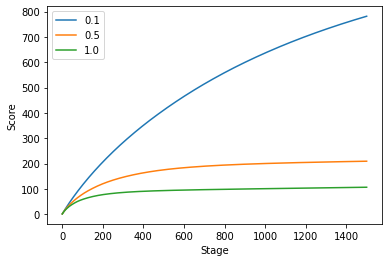

In [101]:
plt.plot(range(1, 1501), np.cumsum(Score[0:1500]), label='0.1')
plt.plot(range(1, 1501), np.cumsum(Score[1500:3000]), label='0.5')
plt.plot(range(1, 1501), np.cumsum(Score[3000:4500]), label='1.0')
plt.xlabel('Stage')
plt.ylabel('Score')
plt.legend()
plt.show

The best learning rate is 0.1. best_nstg is 1500

In [120]:
clf = GradientBoostingClassifier(n_estimators=1500, learning_rate=0.1, random_state=0)

# use x_train and x_valid to train the model
clf.fit(x_train_valid, y_train_valid)

# predict y from x_test
predict_y_test = clf.predict(x_test)

In [121]:
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
  # Accuracy = (TP+TN)/(P+N)
  # Precision = TP/(TP+FP)
  # Recall (TP rate) = TP/P=TP/(TP+FN)
  
  if y_test[i] == 1:
    P += 1
    if predict_y_test[i] == 1:
      TP += 1
    else:
      FN += 1
  else:
    N += 1
    if predict_y_test[i] == 0:
      TN += 1
    else:
      FP += 1

Accuracy = (TP+TN)/(P+N)
Precision = TP/(TP+FP)
Recall = TP/P
Score = clf.score(x_test, y_test)

print("Accuracy of test data is ", Accuracy)
print("Precision of test data is ", Precision)
print("Recall of test data is ", Recall)
print("Recall of test data is ", Recall)
print("Score of test data is ", Score)

Accuracy of test data is  0.8731203007518797
Precision of test data is  0.8371647509578544
Recall of test data is  0.8973305954825462
Recall of test data is  0.8973305954825462
Score of test data is  0.8731203007518797


In [122]:
ind = np.argpartition(clf.feature_importances_, -20)[-20:]
for i in ind:
  print(category[i - 1], "為前20大影響的名字元素")

庭 為前20大影響的名字元素
慈 為前20大影響的名字元素
瑄 為前20大影響的名字元素
芷 為前20大影響的名字元素
涵 為前20大影響的名字元素
芸 為前20大影響的名字元素
婷 為前20大影響的名字元素
哲 為前20大影響的名字元素
佳 為前20大影響的名字元素
承 為前20大影響的名字元素
蓁 為前20大影響的名字元素
柔 為前20大影響的名字元素
妤 為前20大影響的名字元素
雅 為前20大影響的名字元素
萱 為前20大影響的名字元素
晴 為前20大影響的名字元素
柏 為前20大影響的名字元素
翔 為前20大影響的名字元素
宜 為前20大影響的名字元素
怡 為前20大影響的名字元素


Precision與Score更高，但也跑出新的重要元素。

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

In [145]:
clf_1 = LogisticRegression(random_state=0, C=bestc, max_iter=1000)
# use x_train and x_valid to train the model
clf_1.fit(x_stack, y_stack)
# predict y from x_test
predict_y_stack_1 = clf_1.predict_proba(x_stack)
predict_y_test_1 = clf_1.predict_proba(x_test)

clf_2 = RandomForestClassifier(random_state=0, n_estimators=int(best_nest))
# use x_train and x_valid to train the model
clf_2.fit(x_stack, y_stack)
# predict y from x_test
predict_y_stack_2 = clf_2.predict_proba(x_stack)
predict_y_test_2 = clf_2.predict_proba(x_test)

clf_3 = GradientBoostingClassifier(n_estimators=1500, learning_rate=0.1, random_state=0)
# use x_train and x_valid to train the model
clf_3.fit(x_stack, y_stack)
# predict y from x_test
predict_y_stack_3 = clf_3.predict_proba(x_stack)
predict_y_test_3 = clf_3.predict_proba(x_test)


# clf = LogisticRegression(random_state=0, penalty='none' , max_iter=1000)
# clf.fit(x_stack, y_stack)
# score = clf.score(x_valid, y_valid)

In [146]:
X = np.c_[predict_y_stack_1[:, 0], predict_y_stack_2[:, 0], predict_y_stack_3[:, 0]]
Y = np.c_[predict_y_test_1[:, 0], predict_y_test_2[:, 0], predict_y_test_3[:, 0]]

In [147]:
Y

array([[3.10195604e-05, 2.10526316e-02, 1.13452894e-02],
       [9.13423518e-01, 7.57894737e-01, 8.70585834e-01],
       [5.84808092e-01, 3.68421053e-01, 2.57921621e-01],
       ...,
       [9.99991966e-01, 9.89473684e-01, 9.82174408e-01],
       [9.94634266e-01, 8.94736842e-01, 6.68093428e-01],
       [9.99640926e-01, 8.73684211e-01, 9.81814283e-01]])

In [148]:
clf = LogisticRegression(random_state=0, penalty='none', max_iter=1000)
# use x_train and x_valid to train the model
clf.fit(X, y_stack)
# predict y from x_test
predict_y_test = clf.predict(Y)

In [152]:
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
  # Accuracy = (TP+TN)/(P+N)
  # Precision = TP/(TP+FP)
  # Recall (TP rate) = TP/P=TP/(TP+FN)
  
  if y_test[i] == 1:
    P += 1
    if predict_y_test[i] == 1:
      TP += 1
    else:
      FN += 1
  else:
    N += 1
    if predict_y_test[i] == 0:
      TN += 1
    else:
      FP += 1

Accuracy = (TP+TN)/(P+N)
Precision = TP/(TP+FP)
Recall = TP/P

print("Accuracy of test data is ", Accuracy)
print("Precision of test data is ", Precision)
print("Recall of test data is ", Recall)
print("Recall of test data is ", Recall)
print("Score of test data is ", Score)

Accuracy of test data is  0.7885338345864662
Precision of test data is  0.8075117370892019
Recall of test data is  0.7063655030800822
Recall of test data is  0.7063655030800822
Score of test data is  0.8731203007518797


Stacking後的預測能力反而變差。

------
### Solution
------
請自行增加Cell並回答問題。

## 第二題 [Data Visualization via Dimensionality Reduction]

Data visualization is a useful technique that can help us understand the characteristics of a dataset. We are going to practice this skill using the  University Offer of Admission Dataset (UDOAD).  

#### Dataset: University Department Offer of Admission Dataset (UDOAD; 大學推薦甄選資料集)

Many high school students get admitted to universities through an application and screening process that requires each university department to offer admission to applicants first before students can choose where they want to go. Suppose we think of applicants as the customers of an academic department. In that case, the duplications of offered applicants from different departments can be used to understand the competitive relationships between academic departments. We are going to visualize this competition relationship using UDOAD. 

UDOAD was collected through a popular online offer searching service (https://freshman.tw/; site no longer operational) for the 2017 academic year. We collected the offers received by each applicant as well as the basic information for academic departments. This dataset contains two files
* student_admission106.csv: the offers received by each student applicant. 
* univ_name106short1.csv: the basic information, such as the name and field of academic departments. 

Below is the first few records of these two files:

In [153]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving student_admission106.csv to student_admission106.csv
User uploaded file "student_admission106.csv" with length 9667300 bytes


In [154]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving univ_name106short1.csv to univ_name106short1.csv
User uploaded file "univ_name106short1.csv" with length 213460 bytes


In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


,school_id,department_id,student_id,student_name,state,location1,location2
0,001,001012,10246842,黃士玹,正1,南部,台南考區
1,001,001012,10042237,黃冠婷,正2,北部,台北考區
2,001,001012,10008031,鍾大方,正3,北部,台北考區
3,001,001012,10201525,曾信豪,正4,中部,彰化考區
4,001,001012,10014615,陳品儒,正5,北部,台北考區
5,001,001012,10294018,侯思筠,正6,東部,宜蘭考區
6,001,001012,10022810,吳悅慈,正7,北部,台北考區
7,001,001012,10236223,陳俞潔,正8,南部,台南考區
8,001,001012,10025909,蕭宇廷,正9,北部,台北考區
9,001,001012,10123708,吳岱軒,正10,北部,中壢考區


The department_id can uniquely identify an academic department. We do not care about the ranking of admission here, and you should ignore the "state" column. We only care about the "co-application" relations in this dataset. You should use student_id to identify a student applicant uniquely. 

In [156]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


,year,school_id,department_id,school_name,department_name,category_id,category_name,school_name_abbr,department_name_abbr
0,106,006,006042,國立政治大學,教育學系,1,教育,政大,教育
1,106,006,006052,國立政治大學,教育學系(公費生),1,教育,政大,教育(公)
2,106,006,006062,國立政治大學,教育學系(原住民公費生),1,教育,政大,教育(原住民)
3,106,006,006022,國立政治大學,歷史學系,2,藝術及人文,政大,歷史
4,106,006,006152,國立政治大學,民族學系,2,藝術及人文,政大,民族學
5,106,006,006032,國立政治大學,哲學系,2,藝術及人文,政大,哲學
6,106,006,006262,國立政治大學,英國語文學系,2,藝術及人文,政大,英國語文
7,106,006,006292,國立政治大學,日本語文學系,2,藝術及人文,政大,日本語文
8,106,006,006272,國立政治大學,阿拉伯語文學系,2,藝術及人文,政大,阿拉伯語文
9,106,006,006302,國立政治大學,韓國語文學系,2,藝術及人文,政大,韓國語文


You can use this dataset to identify the name of a department_id. The school_name and department_name contain the "full name" of an academic department. To facilitate visualization, we also provide "shorter names" in school_name_abbr and department_name_abbr. The category_name is the field of an academic department. This field is essential in our visualization exercise since you should color each data point according to its category_name. 

#### Implementation Restrictions
You are allowed to use any Python libraries in your solution. 

### Data Preparation
Our focus is on the relationships between departments. To do this, we need to convert the raw data into a "matrix" representation. Each row represents an academic department, and each column represents a student applicant. The cell's value is one if a student applied for admission to the corresponding academic department, and 0 otherwise. 

To avoid potential numerical problems, we only include an academic department if it received ten or more applications. Moreover, we only include a student applicant if he or she applied for more than one academic department. 

Note that the two conditions should be satisfied "as is" in after preprocessing. For example, suppose a student applied for two departments in the original dataset, and one of the departments was removed. In that case, this student should be removed because the student only applied for one department in the processed dataset. 



In [157]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


Report the number of academic departments and student applicants in the processed dataset: 

In [158]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In final dataset, there are 1917 academic departments and 47386 student applicants.


Report the top ten departments that received the most applications and the number of applications they received:

In [159]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [160]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

,department_id,department_name,num_applicant
0,008122,中原機械工程學,386.0
1,012052,中醫藥學,376.0
2,046032,銘傳會計（臺北）,367.0
3,004382,成大電機,357.0
4,005192,東吳企業管理,353.0
5,008112,中原土木,353.0
6,005182,東吳會計,351.0
7,015342,逢甲財金,340.0
8,045012,義守電機,339.0
9,046162,銘傳應用英語（桃園）,329.0


### Answer the following questions
Visualize academic departments in the following questions. In all plots, you should color data points according to the academic department's category. Moreover, you should provide a legend or a picture that illustrates the mapping between colors and category names. Visualize the data using two-dimensional plots. Note that it is your responsibility to study the documentation of your choice libraries and make sure that the results are reasonable. 
* Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

---
### Solution
---

Add cells below and answer the questions below.

In [ ]:
# 2.1

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib import font_manager

from sklearn.decomposition import PCA
pca = PCA(n_components=8)

X_r = pca.fit(dep_stu2).transform(dep_stu2)

print(
    "explained variance ratio (first eight components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first eight components): [0.00502857 0.00455317 0.00404963 0.0039907  0.00331849 0.00318121
 0.00312216 0.00293782]


Because the first two PCs' explained variances are the largest, we choose them to visualize. 

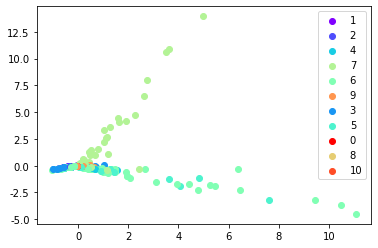

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_r.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_r[i, 0], X_r[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i]) # 我真的印不出中文字...
  else:
    plt.scatter(X_r[i, 0], X_r[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend()

可以看的出來從PCA方法中，只有category6, 7，也就是「工程、製造及營建」與「醫藥衛生及社會福利」能表現出與其他分類不同的分布。

In [ ]:
# 2.2

from sklearn.manifold import MDS

mds = MDS(n_components=2)
nmds = MDS(n_components=2, metric= False)

# X_transformed = embedding.fit_transform(dep_stu2)

pos = mds.fit_transform(dep_stu2)

npos = nmds.fit_transform(dep_stu2)

Text(0.5, 1.0, 'MDS with metric')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


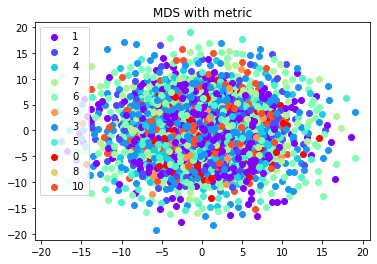

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(pos.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(pos[i, 0], pos[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(pos[i, 0], pos[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("MDS with metric")

Text(0.5, 1.0, 'MDS with non-metric')

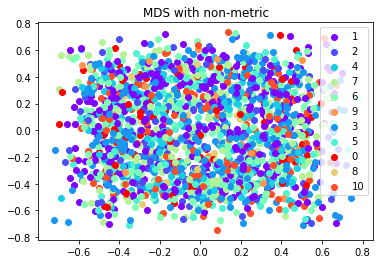

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(npos.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(npos[i, 0], npos[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(npos[i, 0], npos[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("MDS with non-metric")

不管事metric抑或是non-metic的MDS，都無法藉由此方法跑出的兩項變數去有效區分各category，metric整體分布較像橢圓形，而non-metic的整體分布則向矩形。

In [ ]:
# 2.3
# Visualize academic departments using Locally Linear Embedding. Consider three variations: 
# (1) Use 20 neighbors to construct the weight matrix; 
# (2) Use 40 neighbors to construct the weight matrix;
# (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result.

from sklearn.manifold import LocallyLinearEmbedding

embedding_20 = LocallyLinearEmbedding(n_neighbors=20)
X_transformed_20 = embedding_20.fit_transform(dep_stu2)

array([[ 0.00832627,  0.0008909 ],
       [ 0.00169972,  0.00095517],
       [ 0.01816192,  0.0007238 ],
       ...,
       [-0.02859194,  0.00152609],
       [-0.0108061 ,  0.00122473],
       [-0.00268603,  0.00108415]])

Text(0.5, 1.0, 'LLE')

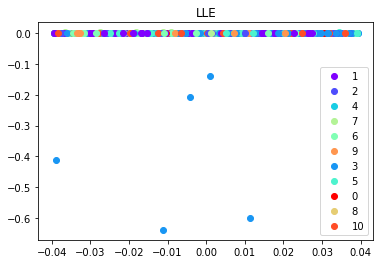

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_transformed_20.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_transformed_20[i, 0], X_transformed_20[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_transformed_20[i, 0], X_transformed_20[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("LLE_20")

In [ ]:
embedding_40 = LocallyLinearEmbedding(n_neighbors=40)
X_transformed_40 = embedding_40.fit_transform(dep_stu2)

array([[9.42670190e-04, 1.12674964e-03],
       [3.49962563e-05, 1.63376470e-03],
       [1.32238095e-03, 1.86698311e-03],
       ...,
       [1.01788165e-03, 1.34802791e-03],
       [1.18708910e-03, 1.53515729e-03],
       [7.61258132e-04, 9.92853014e-04]])

Text(0.5, 1.0, 'LLE_40')

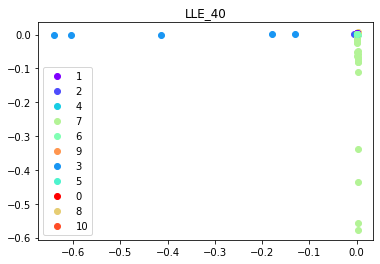

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_transformed_40.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_transformed_40[i, 0], X_transformed_40[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_transformed_40[i, 0], X_transformed_40[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("LLE_40")

In [ ]:
pca = PCA(n_components=100)
X_r = pca.fit(dep_stu2).transform(dep_stu2)
embedding_PCA = LocallyLinearEmbedding(n_neighbors=20)
X_transformed_PCA = embedding_PCA.fit_transform(X_r)

Text(0.5, 1.0, 'LLE_PCA')

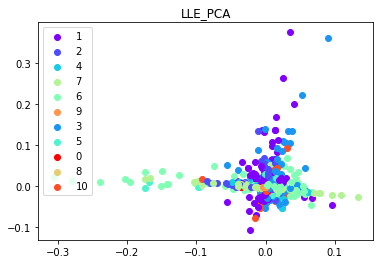

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_transformed_PCA.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_transformed_PCA[i, 0], X_transformed_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_transformed_PCA[i, 0], X_transformed_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("LLE_PCA")

可以看的出來n_neighbor為20抑或40的原本LLE模型表現都不佳，但是經過PCA後表現提升不少。

In [ ]:
# 2.4
# Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel.
# It is your responsibility to select reasonably good kernel parameters. Discuss the result.

from sklearn.decomposition import KernelPCA

transformer_RBF = KernelPCA(n_components=2, kernel='rbf')
X_transformed_RBF = transformer_RBF.fit_transform(dep_stu2)

transformer_Cosine = KernelPCA(n_components=2, kernel='cosine')
X_transformed_Cosine = transformer_Cosine.fit_transform(dep_stu2)

(1917, 2)

Text(0.5, 1.0, 'Kernel PCA with RBF')

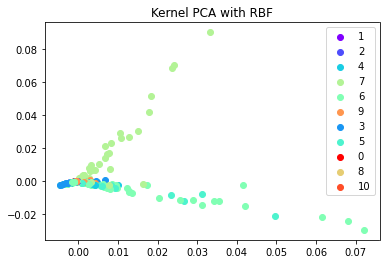

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_transformed_RBF.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_transformed_RBF[i, 0], X_transformed_RBF[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_transformed_RBF[i, 0], X_transformed_RBF[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("Kernel PCA with RBF")

Text(0.5, 1.0, 'Kernel PCA with Cosine')

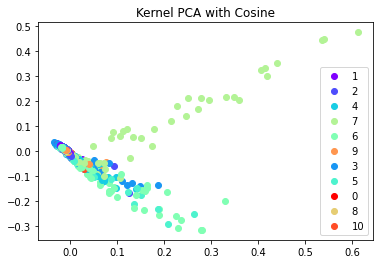

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_transformed_Cosine.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_transformed_Cosine[i, 0], X_transformed_Cosine[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_transformed_Cosine[i, 0], X_transformed_Cosine[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("Kernel PCA with Cosine")

以上兩者都只能大致上辨別部分category6, 7。

In [ ]:
# 2.5
# Visualize academic departments using t-SNE. You should consider at least the Euclidean, Cosine, and Jaccard metric.
# Set numpy random seed so that your results can be repeated. Discuss the result.

from sklearn.manifold import TSNE

TSNE_eu = TSNE(n_components=2, metric = "euclidean")
X_embedded_eu = TSNE_eu.fit_transform(dep_stu2)

TSNE_co = TSNE(n_components=2, metric = "cosine")
X_embedded_co = TSNE_co.fit_transform(dep_stu2)

TSNE_ja = TSNE(n_components=2, metric = "jaccard")
X_embedded_ja = TSNE_ja.fit_transform(dep_stu2)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed t

Text(0.5, 1.0, 't-SNE with Euclidean')

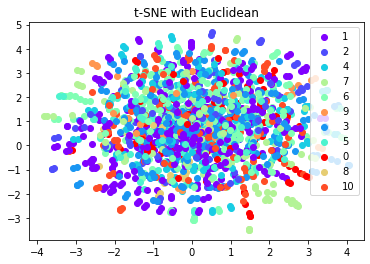

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_embedded_eu.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_embedded_eu[i, 0], X_embedded_eu[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_embedded_eu[i, 0], X_embedded_eu[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("t-SNE with Euclidean")

Text(0.5, 1.0, 't-SNE with Cosine')

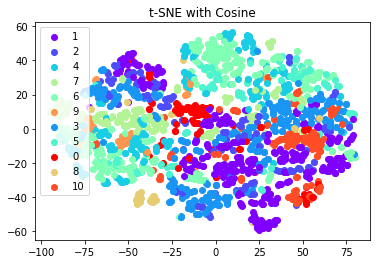

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_embedded_co.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_embedded_co[i, 0], X_embedded_co[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_embedded_co[i, 0], X_embedded_co[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("t-SNE with Cosine")

Text(0.5, 1.0, 't-SNE with Jaccard')

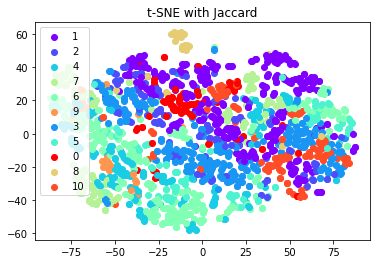

In [ ]:
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_embedded_ja.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_embedded_ja[i, 0], X_embedded_ja[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_embedded_ja[i, 0], X_embedded_ja[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("t-SNE with Jaccard")

Metric設為Euclidean的表現不佳，但是其他兩者的表現似乎補足了其他method的弱勢，較可以分出除了category6, 7以外的類別。

2.6

綜合上述結果，我選擇先使用PCA選出100個PC，再試著套入t-SNE with Cosine以及t-SNE with Jaccard。

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


0 : 教育
1 : 藝術及人文
2 : 社會科學、新聞學及圖書資訊
3 : 商業、管理及法律
4 : 自然科學、數學及統計
5 : 資訊通訊科技
6 : 工程、製造及營建
7 : 醫藥衛生及社會福利
8 : 其他
9 : 農業、林業、漁業及獸醫
10 : 服務


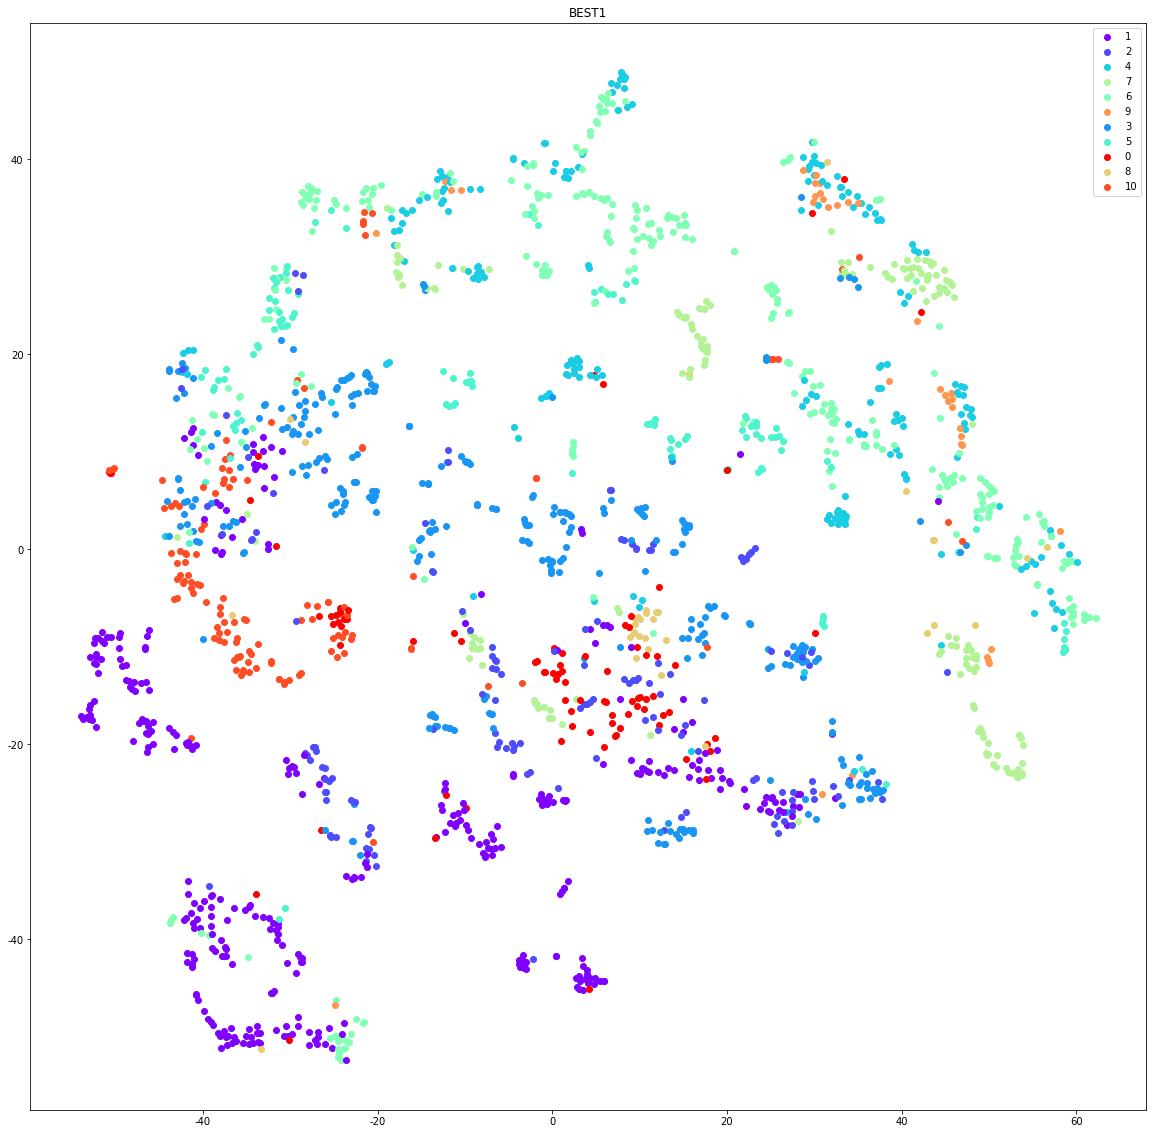

In [ ]:
# Select the most promising visualization method in the previous question and refine the result.
# You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture.
# Moreover, you should try to reduce the problem caused by overlapping points and labels.
# Output an image that is large enough so that a user can easily identify a department and its neighbors.
# Jupyter Lab has limitations on the largest picture size.
# To overcome this problem, output the picture to a separate file and submit the file for grading.
# Your score depends on how useful, readable, and visually pleasing of your visualization results.


pca = PCA(n_components=100)
X_r = pca.fit(dep_stu2).transform(dep_stu2)
TSNE_co = TSNE(n_components=2, metric = "cosine")
X_embedded_co_PCA = TSNE_co.fit_transform(X_r)

plt.figure(figsize=(20, 20))
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_embedded_co_PCA.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_embedded_co_PCA[i, 0], X_embedded_co_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_embedded_co_PCA[i, 0], X_embedded_co_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("BEST1")
plt.savefig('hw3.png')

for i in range(len(category_levels)):
  print(i, ":", category_levels[i])


In [ ]:
plt.savefig('hw3.png')

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarn

Text(0.5, 1.0, 'BEST2')

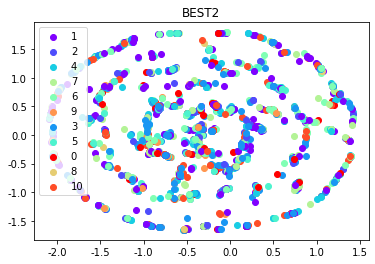

In [ ]:
pca = PCA(n_components=100)
X_r = pca.fit(dep_stu2).transform(dep_stu2)
TSNE_ja = TSNE(n_components=2, metric = "jaccard")
X_embedded_ja_PCA = TSNE_ja.fit_transform(X_r)

plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 11))

already_label = np.array([])

for i in range(X_embedded_ja_PCA.shape[0]):
  if colname_df["category_id"][i] not in already_label:
    already_label = np.append(already_label, colname_df["category_id"][i])
    plt.scatter(X_embedded_ja_PCA[i, 0], X_embedded_ja_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1], label = colname_df["category_id"][i])
  else:
    plt.scatter(X_embedded_ja_PCA[i, 0], X_embedded_ja_PCA[i, 1], color = colors[colname_df["category_id"][i] - 1])

plt.legend(loc="best")
plt.title("BEST2")